In [48]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt

#### Load the data

In [87]:
df= pd.read_csv('./Dataset/train.csv')
df.head(5)
df.iloc[250,1]

'some type and are on a soap box'

In [9]:
df.iloc[7][1]

"Your vandalism to the Matt Shirvington article has been reverted.  Please don't do it again, or you will be banned."

In [10]:
df.iloc[6,2:]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: object

In [11]:
df.shape

(159571, 8)

#### Preprocess the data

In [54]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [55]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [56]:
df.iloc[:,2:].values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [57]:
X = df['comment_text']
y=df.iloc[:,2:].values

In [58]:
MAX_FEATURES = 20000 #number of words in the vocab.The more word embeddings the more efficient model will be.

In [59]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES,output_sequence_length =180,output_mode = 'int')

In [60]:
type(X),type(X.values) # here we convert series to numpy array for further processing

(pandas.core.series.Series, numpy.ndarray)

In [61]:
len(X)

159571

In [62]:
X.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [63]:
X.values

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

In [64]:
vectorizer.adapt(X.values) # teach our vectorizer the vocabulary

In [24]:
vectorized_text = vectorizer(X.values) # after vectorization we pass our X values to convert to sequence of numbers

In [77]:
vectorized_text # ouput after tokenisation and vectorization

<tf.Tensor: shape=(159571, 180), dtype=int64, numpy=
array([[ 643,   76,    2, ...,    0,    0,    0],
       [   1,   54, 2506, ...,    0,    0,    0],
       [ 425,  440,   70, ...,    0,    0,    0],
       ...,
       [   1, 7329,  383, ...,    0,    0,    0],
       [   5,   12,  533, ...,    0,    0,    0],
       [   5,    8,  130, ...,    0,    0,    0]], dtype=int64)>

In [26]:
# tensorflow data pipeline 
#MCSHBAP = map,cache,shuffle,batch,prefetch from tensor_slices,list_file

dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) #helps prevent bottlenecks


In [27]:
type(dataset),len(dataset)

(tensorflow.python.data.ops.dataset_ops.PrefetchDataset, 9974)

In [28]:
batch_X,batch_y = dataset.as_numpy_iterator().next() #to access the data batchwise. As shuffle is true, we get a different dataset every iteration. 
batch_X,batch_y # vectorized text

(array([[   8,  253,   52, ...,    0,    0,    0],
        [  71,    2, 2765, ...,    0,    0,    0],
        [  48,   15,  205, ...,    0,    0,    0],
        ...,
        [   8,   19,   49, ...,    0,    0,    0],
        [   1, 6251,    1, ...,    0,    0,    0],
        [  46,    1,    9, ...,    0,    0,    0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

In [29]:
type(batch_X) ,type(batch_y) 

(numpy.ndarray, numpy.ndarray)

In [30]:
batch_X.shape,batch_y.shape

((16, 180), (16, 6))

In [31]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [32]:
len(train)+len(val)+len(test)

9972

In [33]:
train.as_numpy_iterator().next()

(array([[    8,   455,  1075, ...,     0,     0,     0],
        [ 5273,  1207,  1202, ...,     0,     0,     0],
        [  147,    34,     2, ...,     0,     0,     0],
        ...,
        [    8,   130,    33, ...,     0,     0,     0],
        [    2,   880,   562, ...,     0,     0,     0],
        [ 2169,    76, 16919, ...,     0,     0,     0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

#### Create Sequential Model

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [35]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid')) 

In [39]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          640032    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 731,686
Trainable params: 731,686
Non-trainable params: 0
__________________________________________________

In [40]:
hist = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 579s 82ms/step - loss: 0.0626 - accuracy: 0.9811 - val_loss: 0.0480 - val_accuracy: 0.9445
Epoch 2/5
6981/6981 [==============================] - 754s 108ms/step - loss: 0.0482 - accuracy: 0.9921 - val_loss: 0.0436 - val_accuracy: 0.9937
Epoch 3/5
6981/6981 [==============================] - 3284s 471ms/step - loss: 0.0440 - accuracy: 0.9938 - val_loss: 0.0409 - val_accuracy: 0.9939
Epoch 4/5
6981/6981 [==============================] - 485s 69ms/step - loss: 0.0404 - accuracy: 0.9905 - val_loss: 0.0341 - val_accuracy: 0.9951
Epoch 5/5
6981/6981 [==============================] - 521s 75ms/step - loss: 0.0380 - accuracy: 0.9917 - val_loss: 0.0341 - val_accuracy: 0.9929


In [46]:
hist.history

{'loss': [0.06259305775165558,
  0.04821960628032684,
  0.04396883398294449,
  0.04039263352751732,
  0.03796059265732765],
 'accuracy': [0.9811094403266907,
  0.9921393990516663,
  0.99379563331604,
  0.990492045879364,
  0.9917007088661194],
 'val_loss': [0.04804347828030586,
  0.043602731078863144,
  0.040855199098587036,
  0.03414466604590416,
  0.034128084778785706],
 'val_accuracy': [0.9444897174835205,
  0.993699848651886,
  0.9939192533493042,
  0.9951416850090027,
  0.9929475784301758]}

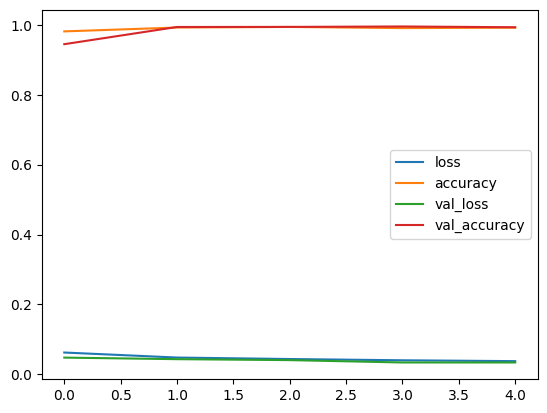

In [49]:
pd.DataFrame(hist.history).plot()
plt.show()

#### Make predictions

In [67]:
batch_X,batch_y = test.as_numpy_iterator().next()

In [68]:

(model.predict(batch_X) > .5).astype(int)

array([[1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [69]:
batch_y

array([[1, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

#### Evaluate the model

In [42]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [43]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [44]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [45]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.835944414138794, Recall:0.7890625, Accuracy:0.4874624013900757


#### Save the model

In [71]:
model.save('toxicity.h5')

#### Test and Gradio

In [95]:
!pip install gradio jinja2

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached importlib_resources-6.1.1-py3-none-any.whl.metadata (4.1 kB)
     ---------------------------------------- 0.0/50.6 kB ? eta -:--:--
     ---------------------------------------- 50.6/50.6 kB 2.5 MB/s eta 0:00:00
  Using cached pydantic-2.6.1-py3-none-any.whl.metadata (83 kB)
     ---------------------------------------- 0.0/45.9 kB ? eta -:--:--
     ---------------------------------------- 45.9/45.9 kB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/124.7 kB ? eta -:--:--
     -------------------------------------- 124.7/124.7 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 3.2 MB/s eta 0:00:00
  Using cached annotated_types-0.6.0-py3-none-any.whl.metadata (12 kB)
INFO: pip is looking at multiple versions of fastapi to determine which versio

  You can safely remove it manually.


In [70]:
import gradio as gr

c:\Users\saras\steffysara\VS_Code_Projects\Comment_Toxicity_Classifier\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [73]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text


In [75]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.components.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')


In [76]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
